In [101]:
import torch
import numpy as np 
import scipy
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm
from models import FFGC, RNNGC
from plotting_functions import *
from dataset import *

In [102]:
res = 64
x = np.linspace(-1, 1, res)*2*np.pi
y = np.linspace(-1, 1, res)*2*np.pi
xx, yy = np.meshgrid(x,y)
mesh = np.stack([xx.ravel(), yy.ravel()], axis = -1)
space_maps = mesh.T.reshape(-1,res,res)

In [103]:
def ratemaps_fn(f, mesh, device):
    activity = f(torch.tensor(mesh.astype("float32"), device = device)).detach().cpu().numpy()
    activity = activity.T.reshape(-1,res,res)
    return activity

In [104]:
model = RNNGC()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.load()
model.to(device)

RNNGC(
  (rg): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
  )
  (relu): ReLU()
  (gg): Linear(in_features=256, out_features=256, bias=False)
  (vg): Linear(in_features=2, out_features=256, bias=False)
)

## Show scaled and sorted (on scaled, mean, absolute activity) ratemaps

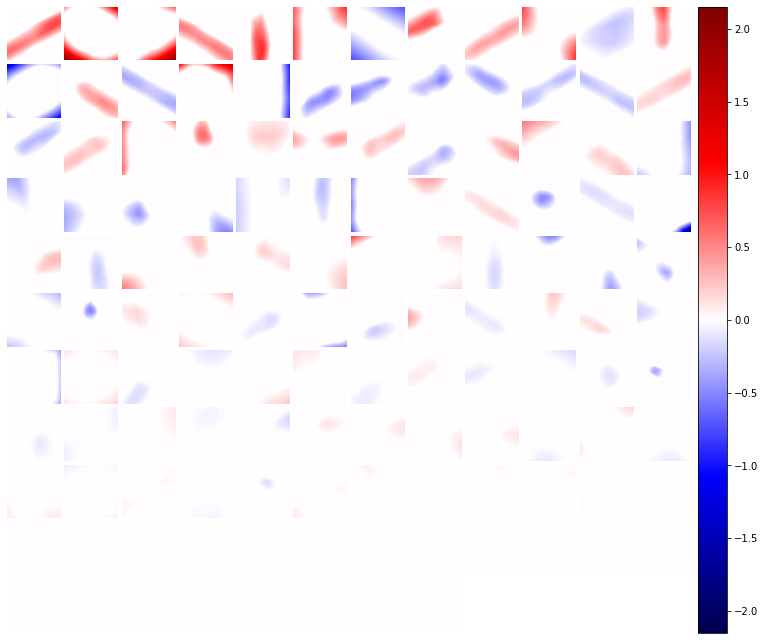

In [108]:
# set the output unit ID and which layer to visualize
output_unit = 2
layer = 2 # ----> CHANGE THIS TO VISUALIZE DIFFERENT LAYERS <----

layer *= 2
weight = model.rg[layer].weight.detach().cpu().numpy()[output_unit][:,None,None]
weighted_ratemaps = ratemaps_fn(model.rg[:layer], mesh, device=device)*weight
sort_idxs = np.argsort(abs(np.sum(weighted_ratemaps,axis=(1,2))))[::-1]
vmin = np.min(weighted_ratemaps)
vmax = np.max(weighted_ratemaps)
vrange = max(abs(vmin), abs(vmax))
multiimshow(weighted_ratemaps[sort_idxs], figsize=(10,10), cmap='seismic', vmin=-vrange, vmax=vrange);

# Show ratemap(s) - including (norm) relu

0.16039042


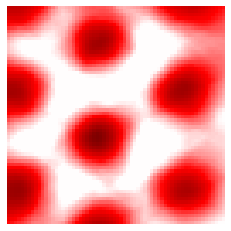

In [109]:
# choose layer ( rg[:2], rg[:4], lambda r: model.norm_relu(model.rg[:6](r)) )
output_unit = 2
f = lambda r: model.norm_relu(model.rg[:6](r)) # ----> CHANGE THIS TO VISUALIZE DIFFERENT LAYERS <----

fig, ax = plt.subplots(figsize=(4,4))
ratemaps = ratemaps_fn(f, mesh, device)
# set output color range
vmin = np.min(ratemaps[output_unit])
vmax = np.max(ratemaps[output_unit])
vrange = max(abs(vmin), abs(vmax))
im = ax.imshow(ratemaps[output_unit], cmap='seismic', vmin=-vrange, vmax=vrange)
ax.axis('off')
#fig.colorbar(im)
print(vrange)

# Show cumulative sum of scaled previous layer activations

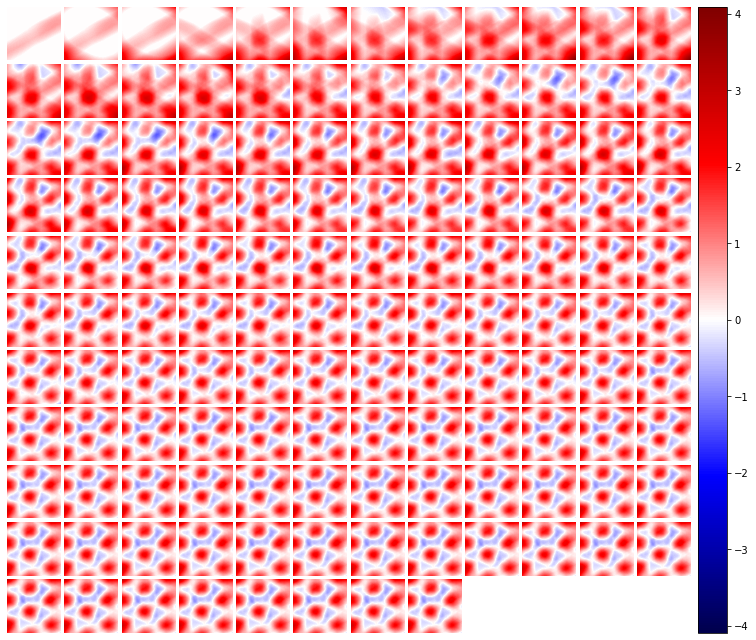

In [110]:
# set the output unit ID and which layer to visualize
output_unit = 2
layer = 2 # ----> CHANGE THIS TO VISUALIZE DIFFERENT LAYERS <----

layer *= 2
weight = model.rg[layer].weight.detach().cpu().numpy()[output_unit][:,None,None]
weighted_ratemaps = ratemaps_fn(model.rg[:layer], mesh, device=device)*weight
sort_idxs = np.argsort(abs(np.sum(weighted_ratemaps,axis=(1,2))))[::-1]
cumulative_weighted_ratemaps = np.cumsum(weighted_ratemaps[sort_idxs], axis=0)
vmin = np.min(cumulative_weighted_ratemaps)
vmax = np.max(cumulative_weighted_ratemaps)
vrange = max(abs(vmin), abs(vmax))
multiimshow(cumulative_weighted_ratemaps, figsize=(10,10), cmap='seismic', vmin=-vrange, vmax=vrange);

In [97]:
dataset = DatasetMaker()
r, v = dataset.generate_data(samples=100000, timesteps=10, device=device)

def rnn_ratemaps_fn(f, r, v, timestep=None, bins=64):
    activity = f((r[:,0], v)).detach().cpu().numpy()
    if timestep is not None:
        activity = activity[:,timestep]
        r = r[:,timestep]
    else:
        activity = activity.reshape(-1, activity.shape[-1]) # (bs*timesteps, units)
        r = r.reshape(-1, r.shape[-1])
    return scipy.stats.binned_statistic_2d(*r.detach().cpu().numpy().T, activity.T, bins=bins, statistic='mean').statistic

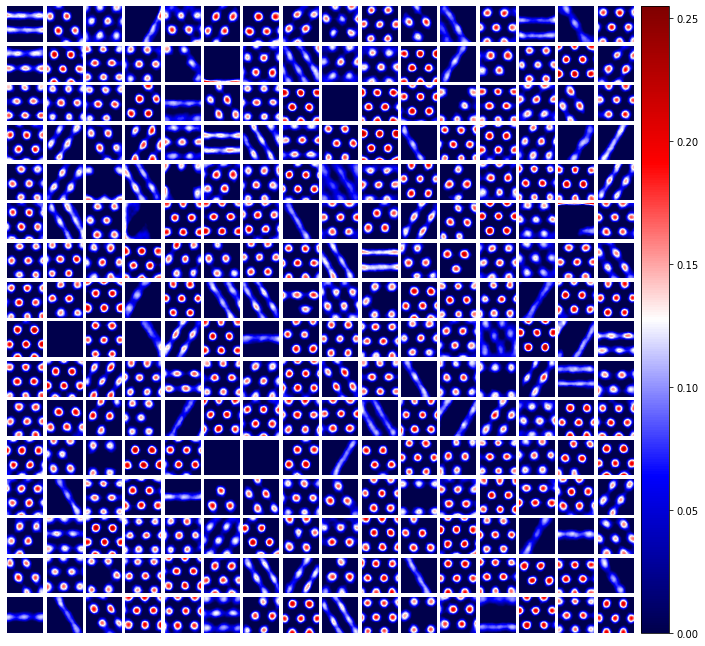

In [111]:
ratemaps = rnn_ratemaps_fn(model, r, v, timestep=0)
multiimshow(ratemaps, figsize=(10,10), cmap='seismic');

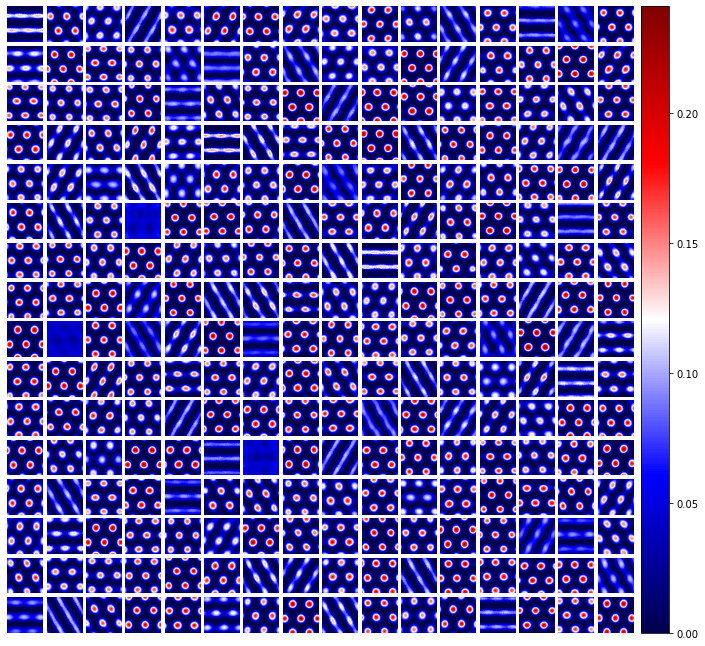

In [112]:
ratemaps = rnn_ratemaps_fn(model, r, v, timestep=9)
multiimshow(ratemaps, figsize=(10,10), cmap='seismic');